In [83]:
import numpy as np
import math


class NetOperation():

  def forward():
    pass

  def backward():
    pass

  def optimize():
    pass


class Layer(NetOperation):
  def __init__(self, n_in: int, n_out: int):
    self.weights = np.random.randn(n_in, n_out)
    self.bias = np.zeros(shape=(1, n_out))

  # z = a1w1 + a2w2 + a3w3 + ... + b
  def forward(self, a):
    self.a = a
    return a.dot(self.weights) + self.bias

  # dgrad = dL / z
  # dL / dwi = dL / dz * dz / dwi
  def backward(self, grad):
    # print(f'Layer backward grad received: {grad}')
    # print(f"self.a: {self.a}")
    self.grad_weights = self.a.T.dot(grad)
    self.grad_bias = np.mean(grad, axis=0)
    # DUVIDA PRIMORDIAL (PRECISO VER ISSO, NÃO ENTENDI MUITO BEM)
    # peguei do código da luiza a ideia
    # print(f'grad: {grad}')
    # print(f'self.weights.T: {self.weights.T}')
    return grad.dot(self.weights.T)

  def optimize(self, learning_rate):
    # print(f'Doing optimization with: {self.grad_weights}')
    self.weights -= self.grad_weights * learning_rate
    self.grad_weights = None

    self.bias -= self.grad_bias * learning_rate
    self.grad_bias = None


class ReLU(NetOperation):
  # a: activation
  # z: weighted sum

  # a = f(z)
  def f(self, z):
    return np.maximum(0, z)

  # da / dz
  # a = df(z)
  def df(self, z):
    return np.greater(0, z).astype(int)

  def forward(self, z):
    self.z = z
    return self.f(z)

  # dgrad = dL / da
  # dL / dz = da / dz * dL / da
  def backward(self, grad):
    return self.df(self.z) * grad

  def optimize(*args, **kwargs):
    pass


class Sigmoid(NetOperation):
  # a: activation
  # z: weighted sum

  def f(self, z, threshold = 10000):
    return 1 / (1 + np.minimum(np.exp(-z), [threshold]))

  def df(self, z):
    s = self.f(z)
    return s * (1 - s)

  def forward(self, z):
    self.z = z
    return self.f(z)

  def backward(self, grad):
    return self.df(self.z) * grad

  def optimize(*args, **kwargs):
    pass

In [84]:
from math import inf
from matplotlib import pyplot as plt

def encode_target(target):
  encoded_targets = []
  for item in target:
    encoding = np.zeros(10)
    encoding[item] = 1
    encoded_targets.append(encoding)

  return np.array(encoded_targets)

def MSELoss(prediction, target):
  n = len(target)
  encoded_targets = encode_target(target)
  
  return (1 / n) * (1 / 2) * np.sum((encoded_targets - prediction) ** 2)


def dMSELoss(prediction, target):
  n = len(target)
  encoded_targets = encode_target(target)
  return (1 / n) * encoded_targets - prediction


class MLP(NetOperation):
  layers: list[NetOperation]

  def __init__(self, layers: list[NetOperation]):
    self.layers = layers

  def forward(self, x):
    activation = x

    # print(f"Forward initial activation: {activation}")

    for layer in self.layers:
      # print(f"At layer {layer}")
      activation = layer.forward(activation)
      # print(f"New activation: {activation}")

    return activation

  # [Sigmoid(), Layer, ReLU, Layer, ReLU, Layer]
  # propagate error
  def backward(self, grad):
    self.layers.reverse()

    for layer in self.layers:
      grad = layer.backward(grad)

    self.layers.reverse()

  def optimize(self, learning_rate):
    for i, layer in enumerate(self.layers):
      # if hasattr(layer, 'weights'):
      #   print(f"Layer {i} weights before optimize:")
      #   print(layer.weights)
      layer.optimize(learning_rate)
      # if hasattr(layer, 'weights'):
      #   print(f"Layer {i} weights after optimize:")
      #   print(layer.weights)

  def train(self, X, Y, learning_rate, batch_size, epochs):

    xs = range(epochs)
    losses = []
    for epoch in xs:
      print(f'Epoch {epoch}')
      lower_loss = inf
      for i in range(0, len(X), batch_size):
        train_samples = X[i: i + batch_size]
        target_samples = Y[i: i + batch_size]

        predictions = self.forward(train_samples)
        # as vezes o erro retornava nan ou inf
        # print(f'target_samples: {target_samples}')
        # print(f'predictions: {predictions}')
        loss = MSELoss(predictions, target_samples)
        d_mse_loss = dMSELoss(predictions, target_samples)
        lower_loss = min(lower_loss, loss)
        self.backward(d_mse_loss)
        self.optimize(learning_rate)

      print(f'loss: {lower_loss}')
      losses.append(lower_loss)

    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.plot(xs, losses)

MNIST

In [85]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [86]:
print(f"train_X.shape: {train_X.shape}")
print(f"train_y.shape: {train_y.shape}")
print(f"test_X.shape: {test_X.shape}")
print(f"test_y.shape: {test_y.shape}")

train_X = train_X.reshape(
    (train_X.shape[0], train_X.shape[1] * train_X.shape[2]))
train_y = train_y.reshape((train_y.shape[0], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))
test_y = test_y.reshape((test_y.shape[0], 1))

print(f"train_X.shape: {train_X.shape}")
print(f"train_y.shape: {train_y.shape}")
print(f"test_X.shape: {test_X.shape}")
print(f"test_y.shape: {test_y.shape}")

train_X.shape: (60000, 28, 28)
train_y.shape: (60000,)
test_X.shape: (10000, 28, 28)
test_y.shape: (10000,)
train_X.shape: (60000, 784)
train_y.shape: (60000, 1)
test_X.shape: (10000, 784)
test_y.shape: (10000, 1)


Epoch 0


/tmp/ipykernel_9872/3658079547.py:80: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.minimum(np.exp(-z), [threshold]))


loss: 2.3124875243702507
Epoch 1
loss: 4.312500001874625
Epoch 2
loss: 4.3750000012497505
Epoch 3
loss: 4.3750000012497505
Epoch 4
loss: 4.3750000012497505
Epoch 5
loss: 4.3750000012497505
Epoch 6
loss: 4.3750000012497505
Epoch 7
loss: 4.3750000012497505
Epoch 8
loss: 4.3750000012497505
Epoch 9
loss: 4.3750000012497505
Epoch 10
loss: 4.3750000012497505
Epoch 11
loss: 4.3750000012497505
Epoch 12
loss: 4.3750000012497505
Epoch 13
loss: 4.3750000012497505
Epoch 14
loss: 4.3750000012497505
Epoch 15
loss: 4.3750000012497505
Epoch 16
loss: 4.3750000012497505
Epoch 17
loss: 4.3750000012497505
Epoch 18
loss: 4.3750000012497505
Epoch 19
loss: 4.3750000012497505
Epoch 20
loss: 4.3750000012497505
Epoch 21
loss: 4.3750000012497505
Epoch 22
loss: 4.3750000012497505
Epoch 23
loss: 4.3750000012497505
Epoch 24
loss: 4.3750000012497505
Epoch 25
loss: 4.3750000012497505
Epoch 26
loss: 4.3750000012497505
Epoch 27
loss: 4.3750000012497505
Epoch 28
loss: 4.3750000012497505
Epoch 29
loss: 4.3750000012497505

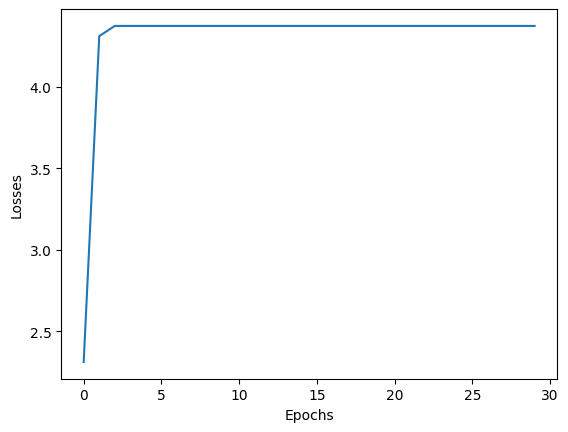

In [87]:
net = MLP([Layer(28 * 28, 512), ReLU(), Layer(512, 10), Sigmoid()])

net.train(train_X, train_y, learning_rate=0.001, batch_size=8, epochs=30)

In [88]:


predictions = net.forward(test_X)
print(np.argmax(predictions, axis=1))
print(test_y)
MSELoss(predictions, test_y)

[0 0 0 ... 0 0 0]
[[7]
 [2]
 [1]
 ...
 [4]
 [5]
 [6]]


/tmp/ipykernel_9872/3658079547.py:80: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.minimum(np.exp(-z), [threshold]))


4.499650000003499